In [1]:
import textacy
import pandas as pd
import spacy
from subject_verb_object_extract import findSVOs
import matplotlib.pyplot as plt
import numpy as np

nlp = spacy.load('en_core_web_lg')

In [2]:
train1 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_1.csv')
train2 = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_train_2.csv')
train = pd.concat([train1, train2])
dev = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_dev.csv')
test = pd.read_csv('../Input_Data/e-SNLI/dataset/esnli_test.csv')

np.random.seed(12345)
cur_train_indices = np.random.random_integers(0, train.shape[0], 200)
train = train.iloc[cur_train_indices]

/var/folders/lp/djryk53n11b_ww_n9xbjm4s80000gn/T/ipykernel_63134/4184760766.py:8: DeprecationWarning: This function is deprecated. Please call randint(0, 549367 + 1) instead
  cur_train_indices = np.random.random_integers(0, train.shape[0], 200)


In [3]:
train[train.notnull().apply(all, axis=1)]

,pairID,gold_label,Sentence1,Sentence2,Explanation_1,WorkerId,Sentence1_marked_1,Sentence2_marked_1,Sentence1_Highlighted_1,Sentence2_Highlighted_1
77285,3978422588.jpg#0r1n,neutral,Two women are walking on the sidewalk and one ...,Two women are going to visit a friend.,Walking on the sidewalk does not necessarily m...,A3MOH6X140NNB9,Two women are walking on the sidewalk and one ...,Two women are *going* *to* *visit* *a* *friend.*,{},"3,4,5,7,6"
135394,4830620136.jpg#4r1e,entailment,Three people are walking down a street.,Three individuals are walking.,People implies they are individuals.,A29GIYJ5MUHBPB,Three *people* are walking down a street.,Three *individuals* are walking.,1,1
87557,4574082050.jpg#2r1e,entailment,A large group of people gather outside a very ...,people are gathered on a busy road,Busy street is the same as busy road.,A3UYOMPM14B3WQ,A large group of people gather outside a very...,people are gathered on a *busy* *road*,"9,10","5,6"
86398,3960632488.jpg#3r1e,entailment,A man and a woman are sitting on the deck of a...,They are on the deck.,A man and a women can be condensed into the pr...,A3MMJ5K2RD4TPQ,A *man* and a *woman* are sitting on the deck...,*They* are on the deck.,"1,4",0
161222,447430161.jpg#2r1n,neutral,There are many people collected in a field.,The people are cult members.,Just because there are many people collected i...,A29N66WIWNN8JK,There are many people collected in a field.,The people *are* *cult* *members.*,{},"3,4,2"
...,...,...,...,...,...,...,...,...,...,...
114439,3537474810.jpg#4r1e,entailment,Man in blue shirt kicks soccer ball.,A man kicks a soccer ball while wearing a blue...,A man in blue shirt implies he is wearing a bl...,A3IAHTO6KDRKTB,*Man* *in* *blue* *shirt* kicks soccer ball.,A man kicks a soccer ball while *wearing* *a*...,"0,1,2,3","7,8,9,10"
116473,2232694969.jpg#0r1n,neutral,A naked child stands facing two wet objects th...,The child is asian.,Not all children are Asian.,A3IB7YJHP04OHI,A naked child stands facing two wet objects th...,The *child* *is* *asian.*,{},"1,2,3"
252476,425775901.jpg#4r1n,neutral,The man is talking in front of the people.,the people are listening to the man poems,Just because a man is talking in front of the ...,A3MOH6X140NNB9,The man is talking in front of the people.,the people are *listening* to the man *poems*,{},"3,7"
32364,3013469764.jpg#2r1c,contradiction,A person is riding an ATV through the dirt.,A person is riding a helicopter through the air.,An ATV and a helicopter are two different type...,A36H650OIIUFT9,A person is riding an *ATV* through the dirt.,A person is riding a *helicopter* through the...,5,5


In [4]:
def extract_SVO(text):
	tuples_list = list()
	tuples = textacy.extract.subject_verb_object_triples(text)
	if tuples:
		tuples_to_list = list(tuples)
		tuples_list.append(tuples_to_list)
	return tuples_list

In [7]:
def findLoc(text):
	res = list()
	for token in text:
		if token.dep_ == 'prep' and token.lemma_ in ['on', 'in']:
			res += list(token.subtree)
	return res

In [8]:
def transform_svo_to_nlp(svos):
	res = list()
	if svos != None:
		for svo in svos:
			res.append([[token for token in nlp(sub_part)] for sub_part in svo])
		return res
	else:
		return svos

In [9]:
SVO_list = []
train['nlp_s1'] = train['Sentence1'].apply(nlp)
train['nlp_s2'] = train['Sentence2'].apply(nlp)
train['svo_s1'] = train['nlp_s1'].apply(findSVOs).apply(transform_svo_to_nlp).apply(lambda x: x if x == None or len(x) == 1 else None)
train['svo_s2'] = train['nlp_s2'].apply(findSVOs).apply(transform_svo_to_nlp).apply(lambda x: x if x == None or len(x) == 1 else None)
train = train[~train.svo_s1.isna() & ~train.svo_s2.isna()]

In [10]:
train['loc_s1'] = train['nlp_s1'].apply(findLoc)
train['loc_s2'] = train['nlp_s2'].apply(findLoc)

In [54]:
train.shape[0] / 200

0.305

## Extract Clothing

### Train Classifier

In [12]:
clothing_words = ['jeans', 'shirt', 'shirts', 'boot', 'boots', 'jacket', 'jackets', 'glove', 'gloves', 'shoe', 'shoes', 'sweater', 'sweaters', 'hat', 'hats', 'skirt', 'skirts', 'beanie', 'beanies', 'blouse', 'blouses', 'tank top', 'tank tops', 'shorts', 'trousers', 'pants', 'skirt', 'skirts', 'jumper', 'suit', 'suits', 'uniform', 'uniforms', 'dress', 'dresses', 'coat', 'coats', 'pullover', 'pullovers', 'sweatshirt', 'sweatshirts', 'cardigan', 'cardigans', 'sandle', 'sandles', 'raincoat', 'raincoats', 'swimsuit', 'scarf', 'hoodie']
other_words = [word for word in list(nlp.vocab.strings) if word not in clothing_words]

In [13]:
def cosine_sim_clothing_word(word, clothing_vectors):
	v1 = nlp.vocab[word].vector
	return max([np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2)) for v2 in clothing_vectors])

In [14]:
all_terms = pd.Series(nlp.vocab.strings)
clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

In [15]:
res = all_terms.apply(cosine_sim_clothing_word, clothing_vectors=clothing_vectors)

In [16]:
label = np.array([1 if word in clothing_words else 0 for word in all_terms])

In [17]:
all_terms = all_terms[[not val for val in res.isna()]]
label = label[[not val for val in res.isna()]]
res = res[[not val for val in res.isna()]]
res = res.reset_index()
res = res.drop(["index"], axis=1)
all_terms = all_terms.reset_index()
all_terms = all_terms.drop(["index"], axis=1)

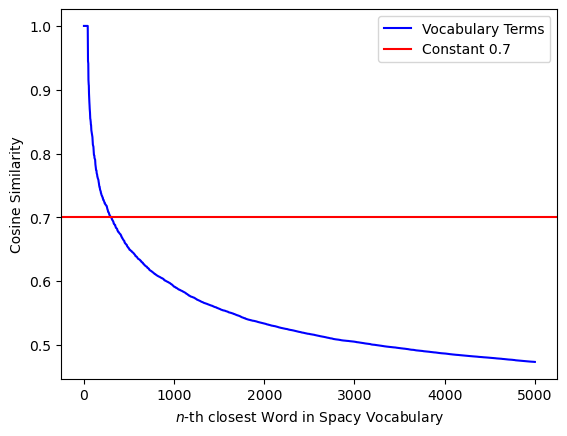

In [61]:
x = np.sort(res[0])[-5000:]
plt.plot(np.arange(len(x), 0, -1), x, c="blue", label="Vocabulary Terms")
plt.axhline(y=0.7, color="red", label="Constant 0.7")
plt.legend()
plt.xlabel("$n$-th closest Word in Spacy Vocabulary")
plt.ylabel("Cosine Similarity")
plt.savefig("cosine_similarity_top5000.pdf")

In [62]:
def cosine_sim(v1, v2):
	return np.dot(v1, v2)  / (np.linalg.norm(v1) * np.linalg.norm(v2))

clothing_vectors = [nlp.vocab[clothing_word].vector for clothing_word in clothing_words]

def findClothing(text):
	# https://stackoverflow.com/questions/53493052/any-elegant-solution-for-finding-compound-noun-adjective-pairs-from-sentence-by
	for token in text:
		if any(np.array([cosine_sim(token.vector, v2) for v2 in clothing_vectors]) > 0.7):
			comps = [j for j in token.children if j.pos_ in ['ADJ', 'NOUN', 'PROPN']]
			if len(comps) > 0:
				return comps + [token, ]
			else:
				return [token, ]

In [63]:
train['clo_s1'] = train['nlp_s1'].apply(findClothing)
train['clo_s2'] = train['nlp_s2'].apply(findClothing)

In [64]:
# How many svo structures are extracted per sentence 1?
train.svo_s1.apply(lambda x: len(x)).value_counts() / train.shape[0]

1    1.0
Name: svo_s1, dtype: float64

In [65]:
# How many svo structures are extracted per sentence 2?
train.svo_s2.apply(lambda x: len(x)).value_counts() / train.shape[0]

1    1.0
Name: svo_s2, dtype: float64

In [66]:
def remove_clo_loc_from_svo(clo, loc, svo):
	if clo is not None:
		clo = clo.copy()
		svo = svo.copy()
		clo_lemmas = [cur_clo.lemma_ for cur_clo in clo]
		for i in range(len(svo)):
			svo[i][0] = [token for token in svo[i][0] if token.lemma_ not in clo_lemmas]
	if loc is not None:
		loc = loc.copy()
		loc_lemmas = [cur_loc.lemma_ for cur_loc in loc]
		for i in range(len(svo)):
			svo[i][0] = [token for token in svo[i][0] if token.lemma_ not in loc_lemmas]
	return svo

def remove_clo_from_loc(clo, loc):
	if clo is not None and loc is not None:
		clo = clo.copy()
		loc = loc.copy()
		clo_lemmas = [cur_clo.lemma_ for cur_clo in clo]
		loc = [token for token in loc if token.lemma_ not in clo_lemmas]
	if loc is not None:
		loc = [token for token in loc if token.text not in ("in", "on") and not token.is_stop]
		if len(loc) == 0:
			return None
	return loc

In [67]:
def svo_to_string(svo):
	try:
		svo = svo[0][1]
		res = [token.text for token in svo]
		res = " ".join(res)
	except:
		res = ""
	return res

In [68]:
train['svo_s1'] = train.apply(lambda x: remove_clo_loc_from_svo(x.clo_s1, x.loc_s1, x.svo_s1), axis=1)
train['svo_s2'] = train.apply(lambda x: remove_clo_loc_from_svo(x.clo_s2, x.loc_s2, x.svo_s2), axis=1)

train['loc_s1'] = train.apply(lambda x: remove_clo_from_loc(x.clo_s1, x.loc_s1), axis=1)
train['loc_s2'] = train.apply(lambda x: remove_clo_from_loc(x.clo_s2, x.loc_s2), axis=1)

In [69]:
train[['Sentence1', 'svo_s1',  'loc_s1', 'clo_s1', 'Sentence2', 'svo_s2', 'loc_s2', 'clo_s2']].head(20)

,Sentence1,svo_s1,loc_s1,clo_s1,Sentence2,svo_s2,loc_s2,clo_s2
135394,Three people are walking down a street.,"[[[Three, people], [walking]]]",None,None,Three individuals are walking.,"[[[Three, individuals], [walking]]]",None,None
87557,A large group of people gather outside a very ...,"[[[A, large, group, of, people], [gather]]]",None,None,people are gathered on a busy road,"[[[], [gather], [people]]]","[busy, road]",None
150147,A woman studies the label on a food product.,"[[[woman], [studies], [the, label]]]","[food, product]",None,The woman looks at the calorie count on the fo...,"[[[woman], [looks]]]","[food, product]",None
52593,A person stands in a vast field of glacial ice.,"[[[person], [stands]]]","[vast, field, glacial, ice]",None,A person is sitting in the sand.,"[[[A, person], [sitting]]]",[sand],None
41842,A young adult is throwing a softball to home b...,"[[[A, young, adult], [throwing], [a, softball]]]",None,None,The third baseman throws the ball.,"[[[The, third, baseman], [throws], [the, ball]]]",None,None
7987,A young man jumps hurdles in a race on a track.,"[[[young, man], [jumps], [hurdles]]]","[race, track, track]",None,A young man is racing,"[[[A, young, man], [racing]]]",None,None
3511,A man and a woman with a head covering are on ...,"[[[], [looking]]]","[bridge, looking, water, boat]",None,A husband and a wife with a head covering are ...,"[[[], [looking]]]","[bridge, looking, water, boat]",None
247252,A man is hanging by a line off a cliff above w...,"[[[A, man], [hanging]]]",None,None,a man fell into the water,"[[[a, man], [fell]]]",None,None
237772,A group of four people congregate on a sidewalk.,"[[[group, of, four, people], [congregate]]]",[sidewalk],None,"The people are shoveling the street,","[[[The, people], [shoveling], [the, street]]]",None,None
219170,A teenager has climbed a tree.,"[[[A, teenager], [climbed], [a, tree]]]",None,None,There is a teenager in a tree.,"[[[There], [is], [a, teenager, in, a, tree]]]",[tree],None


In [71]:
train[['Sentence1', 'svo_s1', 'clo_s1']].head(40)

,Sentence1,svo_s1,clo_s1
135394,Three people are walking down a street.,"[[[Three, people], [walking]]]",None
87557,A large group of people gather outside a very ...,"[[[A, large, group, of, people], [gather]]]",None
150147,A woman studies the label on a food product.,"[[[woman], [studies], [the, label]]]",None
52593,A person stands in a vast field of glacial ice.,"[[[person], [stands]]]",None
41842,A young adult is throwing a softball to home b...,"[[[A, young, adult], [throwing], [a, softball]]]",None
7987,A young man jumps hurdles in a race on a track.,"[[[young, man], [jumps], [hurdles]]]",None
3511,A man and a woman with a head covering are on ...,"[[[], [looking]]]",None
247252,A man is hanging by a line off a cliff above w...,"[[[A, man], [hanging]]]",None
237772,A group of four people congregate on a sidewalk.,"[[[group, of, four, people], [congregate]]]",None
219170,A teenager has climbed a tree.,"[[[A, teenager], [climbed], [a, tree]]]",None


In [36]:
svo_wrong = 7/20 # Vers 1
svo_wrong = 3/20# Vers 2. Classified as wrong also when loc was included in the noun

In [37]:
# Vers 1
loc_wrong = 9 / 40 # for each sentence separately
loc_precision = 1 - 18 / 20

# Vers 2
loc_wrong = 9/40 # oftentimes prepsoition 'at'
loc_precision = 1 - 2/16 # number of loc of all detected ones that are wrong

In [39]:
# Vers 1
clo_wrong = 2 / 40
clo_precision = 1 - 2 / 4 # both just missed some more pieces of clothing than the ones mentioned

# Vers 2
clo_wrong = 5 / 40
clo_precision = 1 - 2/9